## Importing Modules

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob as gb
import pandas as pd

import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.layers import Layer
from tensorflow.keras.layers import Activation, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
# from keras.applications import EfficientNetB4

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check TensorFlow version and GPU availability
print("TensorFlow Version: ", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
TensorFlow Version:  2.13.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data preprocess

In [3]:
base_path = '/kaggle/input/blood-vessel-segmentation/'
models = [
    '/kaggle/input/blood-vessel-segmentation-512x512-1/model_checkpoint.ckpt'
]
    
def plot_image_path(path, idx=0):
    all_path = gb.glob(path)
    image = get_image(all_path[idx])
    print(image.shape)
    tmp = plt.imshow(image, cmap='gray')
    plt.colorbar(tmp)
    
def plot_image(image):
    tmp = plt.imshow(image, cmap='gray')
    plt.colorbar(tmp)

def get_image(path):
    return np.array(Image.open(path)) 

In [4]:
SIZE = 512
SIZE_F = 256.0
TH = 0.999

In [5]:
def augmentation(images, labels):
    new_images = []
    new_labels = []
#     img_shape = get_image(images[0]).shape
#     for i in range(len(images)):
#         img = get_image(images[i])
#         label = get_image(labels[i])
        
#         # Flip left to right
#         new_images.append(np.fliplr(img))
#         new_labels.append(np.fliplr(label))

#         # Flip up to down
#         new_images.append(np.flipud(img))
#         new_labels.append(np.flipud(label))
        
    return np.array(new_images), np.array(new_labels)

In [6]:
def percentile_normalize(image, percentile=0.04):
    lower_limit = np.percentile(image, percentile)
    upper_limit = np.percentile(image, 100. - percentile)
    if upper_limit - lower_limit ==0:
        return image
    normalized_image = np.clip(image, lower_limit, upper_limit)
    normalized_image = (normalized_image - lower_limit) / (upper_limit - lower_limit)
    return normalized_image

In [7]:
def preprocess_image(source, is_image=False):
    if is_image:
        image = percentile_normalize(source)
    else:
        image = percentile_normalize(get_image(source))
    
    if image.ndim > 2 and image.shape[2] > 1:
        image = image[...,0]
    image = image / 4095.
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    if image.ndim == 2:
        image = image[..., tf.newaxis]
        
    if image.ndim != 3:
        raise ValueError('Image tensor must be 3 dimensions [height, width, channels]')
        
    return tf.image.resize(image, [SIZE, SIZE])

def preprocess_label(source, is_image=False):
    if is_image:
        label = source
    else:
        label = get_image(source)
    
    if label.ndim > 2 and label.shape[2] > 1:
        label = label[..., 0]
    label = label / 4095.
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    if label.ndim == 2:
        label = label[..., tf.newaxis]
    
    # Ensure mask tensor is 3D at this point
    if label.ndim != 3:
        raise ValueError('Label tensor must be 3 dimensions [height, width, channels]')
        
    label = tf.image.resize(label, [SIZE, SIZE])
    
    return label

In [8]:
def processing_data(idx=0):
    
    # Kidney 1 dense for learning and Kidney 2 for validation process
    image_files = gb.glob(base_path+'train/kidney_1_dense/images/*')
    label_files = gb.glob(base_path+'train/kidney_1_dense/labels/*')

    # image_files += gb.glob(base_path+'train/kidney_3_sparse/images/*')
    # label_files += gb.glob(base_path+'train/kidney_3_sparse/labels/*')

    image_files_val = gb.glob(base_path+'train/kidney_2/images/*')
    label_files_val = gb.glob(base_path+'train/kidney_2/labels/*')

    # Training on all images
    # image_files = []
    # label_files = []

    # datasets = gb.glob(base_path+'train/*')
    # for dataset in datasets:
    #     image_files += gb.glob(dataset+'/images/*')
    #     label_files += gb.glob(dataset+'/labels/*')
    
    # Using sub arrays for training
    image_subs = np.array_split(image_files, 8)
    label_subs = np.array_split(label_files, 8)
    
    image_subset = image_subs[idx]
    label_subset = label_subs[idx]
    
    # Data Augmentation
    new_images, new_labels = augmentation(image_subset, label_subset)
    print(f'New images created: shape={new_images.shape}, dtype={new_images.dtype}')
    print(f'New labels created: shape={new_labels.shape}, dtype={new_labels.dtype}')
    
    # Preprocessing    
    aug_images = np.array([preprocess_image(i, is_image=True) for i in new_images])
    aug_labels = np.array([preprocess_image(i, is_image=True) for i in new_labels])
    
    images = np.array([preprocess_image(i) for i in image_subset])
    labels = np.array([preprocess_label(i) for i in label_subset])
    print(f'Original Images: shape={images.shape}, dtype={images.dtype}')
    print(f'Original Labels: shape={labels.shape}, dtype={labels.dtype}')
    
    images_val = np.array([preprocess_image(i) for i in image_files_val[:200]])
    labels_val = np.array([preprocess_label(i) for i in label_files_val[:200]])
    print(f'Validation Images: shape={images_val.shape}, dtype={images_val.dtype}')
    print(f'Validation Labels: shape={labels_val.shape}, dtype={labels_val.dtype}')
    
#     images = np.concatenate((images, aug_images), axis=0)
#     labels = np.concatenate((labels, aug_labels), axis=0)
    return images, labels, images_val, labels_val
    
images, labels, images_val, labels_val = processing_data()

New images created: shape=(0,), dtype=float64
New labels created: shape=(0,), dtype=float64
Original Images: shape=(285, 512, 512, 1), dtype=float32
Original Labels: shape=(285, 512, 512, 1), dtype=float32
Validation Images: shape=(200, 512, 512, 1), dtype=float32
Validation Labels: shape=(200, 512, 512, 1), dtype=float32


# Custom Classes

In [9]:
class SentimentSegmentation():

    def __init__(self, x, y, val_x, val_y, input_shape=(SIZE,SIZE,1), encoders=None, decoders=None):
        self.seed = 2024
        self.encoders = encoders
        self.decoders = decoders
        self.x_train = x
        self.y_train = y
        self.x_test = val_x
        self.y_test = val_y
        self.input_shape = input_shape
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        self.generate()
        self.gpus = tf.config.experimental.list_physical_devices('GPU')
        self.checkpoint_path = "/kaggle/working/model_checkpoint.ckpt"
        self.model_checkpoint = ModelCheckpoint(self.checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False)
    
    def check_cp(self):
        if os.path.exists(self.checkpoint_path):
            self.model =  load_model(self.checkpoint_path, custom_objects={
                                                        'bce_dice_loss': self.bce_dice_loss, 
                                                        'dice_coef': self.dice_coef, 
                                                        'iou_coef': self.iou_coef})
        else:
            print('No Checkpoint Available!')
    
    def load_model(self, path):
        if os.path.exists(path):
            self.model =  load_model(path, custom_objects={
                                                        'bce_dice_loss': self.bce_dice_loss, 
                                                        'dice_coef': self.dice_coef, 
                                                        'iou_coef': self.iou_coef})
        else:
            print('No Checkpoint Available!')
    
    def feed_new_data(self, x, y, val_x, val_y):
        self.x_train = x
        self.y_train = y
        self.x_test = val_x
        self.y_test = val_y
        self.check_cp()
        self.fit_gpu()
        
    def seed_everything(seed=2024):
        import random
        random.seed(seed)
        np.random.seed(seed)

    def create_encoder(self, x, conv_num=2, filters_num=64, kernel_size=3, stride=1, padding='same', pool_size=(2, 2)):
        for _ in range(conv_num):
            x = Conv2D(filters=filters_num, kernel_size=(kernel_size, kernel_size), strides=stride, padding=padding)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        x_prime = None

        x = MaxPooling2D(pool_size)(x)
        return x

    def create_decoder(self,x, extra=None, conv_num=2, filters_num=64, kernel_size=3, stride=1, padding='same', pool_size=(2, 2), is_output=False):
        
        
        x = UpSampling2D(pool_size)(x)
        if extra is not None:
            x = Concatenate()([x, extra])
        print('decoder:')
        for i in range(conv_num):
            x = Conv2D(filters=filters_num, kernel_size=(kernel_size, kernel_size), strides=stride, padding=padding)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            print(x.shape)
            
        if is_output:
            x = Conv2D(1, (1, 1), 1, padding="valid")(x)
            x = BatchNormalization()(x)
            print('last_layer:', x.shape)
            x = Reshape((self.input_shape[0]*self.input_shape[1], 1), input_shape=self.input_shape,)(x)
            x = Activation('sigmoid')(x)
            x = Reshape((self.input_shape[0], self.input_shape[1], 1), input_shape=x.shape,)(x)
            
        return x

    def generate(self):
        inputs = Input(shape=self.input_shape)
        base_filter_number = 64
#         backbone = EfficientNetB4(input_shape = self.input_shape, include_top = False,
#                            weights='/kaggle/input/keras-pretrained-models/EfficientNetB4_NoTop_ImageNet.h5',
#                            drop_connect_rate=0.4)(inputs)

        
        
        # Encoders    
        print('Inputs:',inputs.shape)
        c1 = self.create_encoder(inputs, filters_num=base_filter_number * 1)
        print(c1.shape)
        c2 = self.create_encoder(c1, filters_num=base_filter_number * 2)
        print(c2.shape)
        c3 = self.create_encoder(c2, conv_num=3, filters_num=base_filter_number * 4)
        print(c3.shape)
        c4 = self.create_encoder(c3, conv_num=3, filters_num=base_filter_number * 8)
        print(c4.shape)
        c5 = self.create_encoder(c4, conv_num=3, filters_num=base_filter_number * 16)
        print('ta-da',c5.shape,'\n\n')
        
        # Decoders
        dec5 = self.create_decoder(c5, c4, conv_num=3, filters_num=base_filter_number * 16)
        print('after:',dec5.shape)
        dec4 = self.create_decoder(dec5, c3, conv_num=3, filters_num=base_filter_number * 8)
        print('after:',dec4.shape)
        dec3 = self.create_decoder(dec4, c2, conv_num=3, filters_num=base_filter_number * 4)
        print('after:',dec3.shape)
        dec2 = self.create_decoder(dec3, c1, filters_num=base_filter_number * 2)
        print('after:',dec2.shape)
        dec1 = self.create_decoder(dec2, inputs, filters_num=base_filter_number * 1, is_output=True)
        print('after:',dec1.shape)

        self.model = Model(inputs=inputs, outputs=dec1, name="UNet")
        return self.model

    def lr_scheduler(self, epoch, lr):
        decay_rate = 0.1
        decay_step = 10
        
        if epoch % decay_step == 0 and epoch:
            return lr * decay_rate
        return lr

    def dice_coef(self,y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(self,y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou

    def dice_loss(self, y_true, y_pred):
        return 1. - self.dice_coef(y_true, y_pred)

    def bce_dice_loss(self,y_true, y_pred):
        return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred)

    def summary(self):
        return self.model.summary()

    def compile(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.model.compile(optimizer=optimizer, loss=self.bce_dice_loss, metrics=[self.dice_coef,self.iou_coef])

    def fit(self):
        scheduler = LearningRateScheduler(self.lr_scheduler, verbose=1)
        self.model.fit(self.x_train,
                       self.y_train,
                       batch_size=4,
                       epochs=6,
                       validation_data=(self.x_test, self.y_test),
                       callbacks=[self.early_stopping, scheduler, self.model_checkpoint])

    def fit_gpu(self):
        if self.gpus:
            with tf.device('/GPU:0'):
                results = self.fit()
                print("GPU is available and used.")
        else:
            print("No GPU available.")
            self.fit()
            
    def get_model(self):
        return self.model

In [10]:
SS = SentimentSegmentation(images, labels, images_val, labels_val)
SS.compile()
# SS.summary()

Inputs: (None, 512, 512, 1)
(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
ta-da (None, 16, 16, 1024) 


decoder:
(None, 32, 32, 1024)
(None, 32, 32, 1024)
(None, 32, 32, 1024)
after: (None, 32, 32, 1024)
decoder:
(None, 64, 64, 512)
(None, 64, 64, 512)
(None, 64, 64, 512)
after: (None, 64, 64, 512)
decoder:
(None, 128, 128, 256)
(None, 128, 128, 256)
(None, 128, 128, 256)
after: (None, 128, 128, 256)
decoder:
(None, 256, 256, 128)
(None, 256, 256, 128)
after: (None, 256, 256, 128)
decoder:
(None, 512, 512, 64)
(None, 512, 512, 64)
last_layer: (None, 512, 512, 1)
after: (None, 512, 512, 1)


In [11]:
SS.check_cp()
SS.fit_gpu()
# model = SS.get_model()

No Checkpoint Available!

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/6
72/72 [==============================] - ETA: 0s - loss: 0.6987 - dice_coef: 7.9598e-04 - iou_coef: 4.0417e-04
Epoch 1: saving model to /kaggle/working/model_checkpoint.ckpt
72/72 [==============================] - 103s 991ms/step - loss: 0.6987 - dice_coef: 7.9598e-04 - iou_coef: 4.0417e-04 - val_loss: 0.2900 - val_dice_coef: 3.9561e-04 - val_iou_coef: 2.1353e-04 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/6
72/72 [==============================] - ETA: 0s - loss: 0.6608 - dice_coef: 8.3097e-04 - iou_coef: 4.2258e-04
Epoch 2: saving model to /kaggle/working/model_checkpoint.ckpt
72/72 [==============================] - 66s 915ms/step - loss: 0.6608 - dice_coef: 8.3097e-04 - iou_coef: 4.2258e-04 - val_loss: 0.6553 - val_dice_coef: 5.6417e-04 - val_iou_coef: 2.8903e-04 - lr: 0.0010

Epoch 3: LearningRateScheduler sett

In [12]:
for i in range(7):
    images, labels, images_val, labels_val = processing_data(i+1)
    SS.feed_new_data(images, labels, images_val, labels_val)

model = SS.get_model()

New images created: shape=(0,), dtype=float64
New labels created: shape=(0,), dtype=float64
Original Images: shape=(285, 512, 512, 1), dtype=float32
Original Labels: shape=(285, 512, 512, 1), dtype=float32
Validation Images: shape=(200, 512, 512, 1), dtype=float32
Validation Labels: shape=(200, 512, 512, 1), dtype=float32

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/6
72/72 [==============================] - ETA: 0s - loss: 0.5014 - dice_coef: 7.3805e-04 - iou_coef: 3.7738e-04
Epoch 1: saving model to /kaggle/working/model_checkpoint.ckpt
72/72 [==============================] - 84s 940ms/step - loss: 0.5014 - dice_coef: 7.3805e-04 - iou_coef: 3.7738e-04 - val_loss: 1.0464 - val_dice_coef: 5.8183e-04 - val_iou_coef: 2.9618e-04 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/6
72/72 [==============================] - ETA: 0s - loss: 0.4733 - dice_coef: 7.2975e-04 - iou_coef: 3.7375e-04
Epoch 

1/1 [==============================] - 7s 7s/step
0.039024115
0.0384772
0.040453803
0
0
0.0


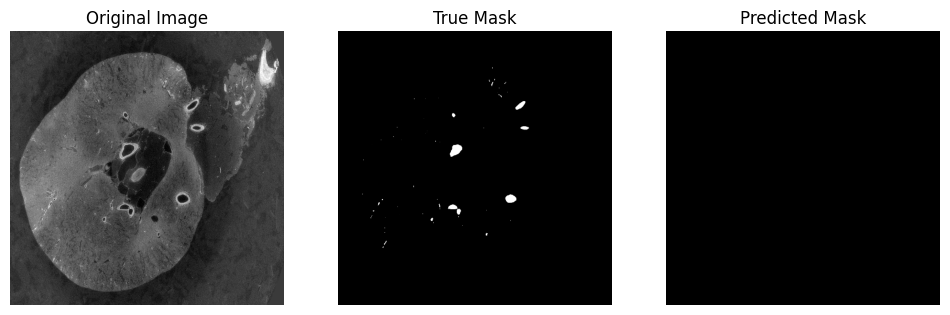

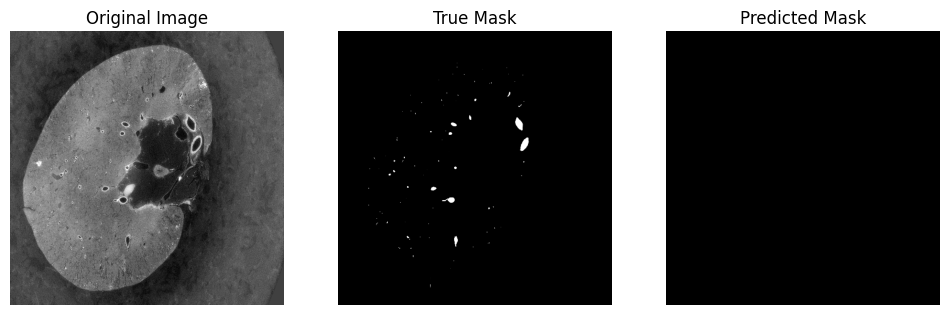

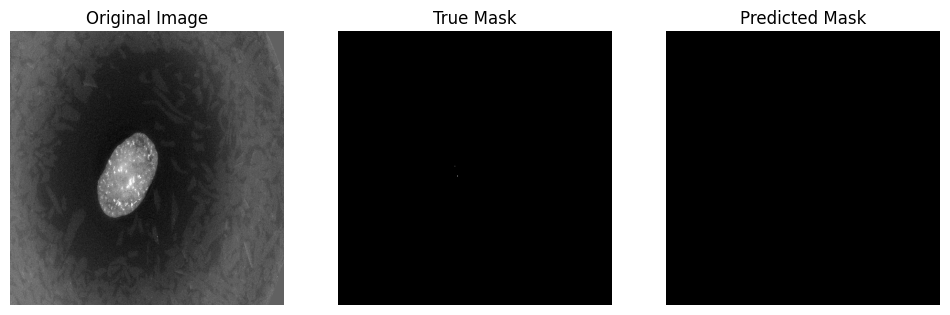

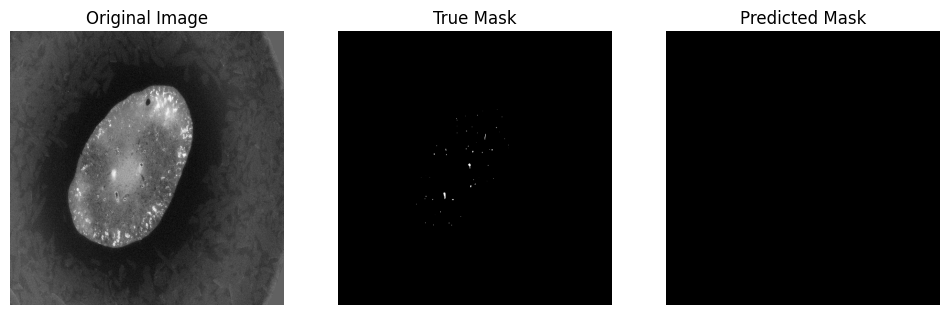

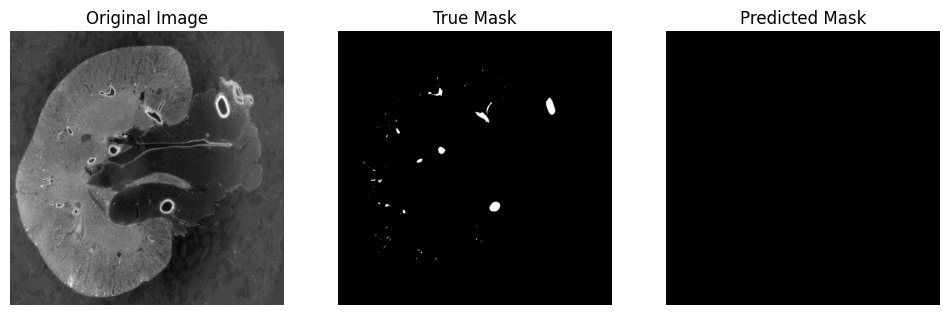

In [13]:
import random
num_samples = 5 
sample_indices = random.sample(range(len(SS.x_test)), num_samples)
sample_images = SS.x_test[sample_indices]
sample_true_masks = SS.y_test[sample_indices]
sample_pred_masks = model.predict(sample_images)
print(np.mean(sample_pred_masks))
print(np.min(sample_pred_masks))
print(np.max(sample_pred_masks))
# Thresholding example (adjust threshold as needed)
sample_pred_masks = (sample_pred_masks > 0.999).astype(np.uint8)
print(np.min(sample_pred_masks))
print(np.max(sample_pred_masks))
print(np.mean(sample_pred_masks[0]))
for i in range(num_samples):
    plt.figure(figsize=(12, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Display true mask
    plt.subplot(1, 3, 2)
    plt.imshow(sample_true_masks[i], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(sample_pred_masks[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [14]:
test_set_path = '/kaggle/input/blood-vessel-segmentation/test'
test_images_path = []

for dirs in gb.glob(test_set_path + '/*'):
    test_images_path += gb.glob(dirs+'/images/*')
        
test_images = np.array([preprocess_image(i) for i in sorted(test_images_path)])

In [15]:
# make predictions
predicted_labels = model.predict(test_images)

1/1 [==============================] - 7s 7s/step


In [16]:
predicted_labels = tf.image.resize(predicted_labels, [1303, 912], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [17]:
np.mean(predicted_labels)

0.038996737

In [18]:
int_labels = (predicted_labels > 0.999)

(1303, 912, 1)
0.0
False


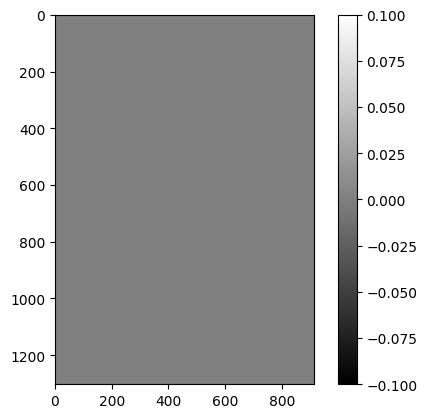

In [19]:
plot_image(int_labels[4])

print(int_labels[4].shape)
print(np.mean(int_labels[4]))
print(np.max(int_labels[4]))

0.00024420026

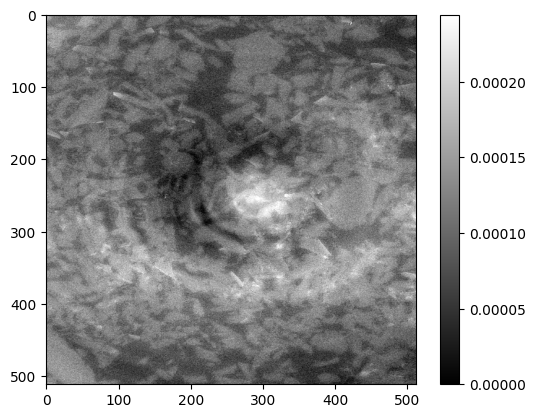

In [20]:
plot_image(test_images[4])
np.mean(test_images[4])
np.max(test_images[4])

In [21]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    img = np.array(img)
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle=='':
        rle = '1 0'
    return rle

In [22]:
all_rle = [rle_encode(label) for label in int_labels]
ids = [f'{p.split("/")[-3]}_{os.path.basename(p).split(".")[0]}' for p in test_images_path]

In [23]:
submission = pd.DataFrame({
    "id": ids,
    "rle": all_rle
})

In [24]:
submission.head()

,id,rle
0,kidney_5_0001,1 0
1,kidney_5_0002,1 0
2,kidney_5_0000,1 0
3,kidney_6_0001,1 0
4,kidney_6_0002,1 0


In [25]:
submission.to_csv("submission.csv", index=False)